In [1]:
import numpy as np
import pandas as pd
from log_analysis import (get_unique_tcp_stream_ids, load_timestamps_from_crawl_data,
                          get_distinct_tcp_conns, get_crawl_data_path,
                          get_crawl_status, get_epoch)

from os.path import isdir, join
from datetime import datetime
from glob import glob

ROKU_WARMUP_CRAWL = 'roku-data-20190427-014017'
crawl_data_dir_roku = get_crawl_data_path(ROKU_WARMUP_CRAWL)

In [2]:
assert isdir(crawl_data_dir_roku)

In [3]:
crawl_results = get_crawl_status(crawl_data_dir_roku)

## Load timestamps

In [4]:
channel_timestamps = load_timestamps_from_crawl_data(crawl_data_dir_roku)

longest_label_set = max(list(channel_timestamps.values()), key=len)
label_set = [i[0] for i in longest_label_set]
smart_crawl_labels = list(filter(lambda x: 'key-seq' in x, label_set))


Loading timestamp data from /home/hooman/Desktop/crawl-data/roku-data-20190427-014017


In [5]:
def get_launch_no(epoch):
    if 'launch' not in epoch:
        return -1
    launch_idx = int(epoch.split("-", 2)[1])
    if "smartlaunch" in epoch:
        return 10 + launch_idx
    elif "launch" in epoch:
        return launch_idx

In [6]:
# Load all (All SSL/TCP Streams)
crawl_name = ROKU_WARMUP_CRAWL
crawl_data_dir = get_crawl_data_path(crawl_name)
print (crawl_data_dir)
post_process_dir = join(crawl_data_dir, 'post-process')
ssl_df = get_distinct_tcp_conns(crawl_data_dir, adBlockStat=False)
ssl_df = ssl_df[ssl_df.tcp_dstport == 443]
#Add SSL artifacts 
# ssl_fails = get_tcp_conns(post_process_dir, "*.pcap.ssl_fail")
ssl_attempts = get_unique_tcp_stream_ids(post_process_dir, "*.pcap.mitmproxy-attempt")
ssl_success = get_unique_tcp_stream_ids(post_process_dir, "*.pcap.ssl_connections")
# print(ssl_success)
ssl_df['mitm_attempt'] = ssl_df.apply(lambda x: x['tcp_stream'] in ssl_attempts[x['channel_id']], axis=1)
# ssl_df['mitm_fail'] = ssl_df.apply(lambda x: x['tcp.stream'] in ssl_fails[x['channel_id']], axis=1)
# mitm_fail doesn't capture some corner cases, we should test and use mitm success
ssl_df['ssl_success'] = ssl_df.apply(lambda x: x['tcp_stream'] in ssl_success[x['channel_id']], axis=1)
ssl_df["crawl_status"] = ssl_df["channel_id"].map(lambda x: crawl_results[x])
ssl_df['epoch'] = ssl_df.apply(lambda x: get_epoch(x, channel_timestamps), axis=1)
ssl_df['n_smart_crawl_launch'] = ssl_df['epoch'].map(lambda x: int(x.split('-')[1]) if 'key-seq' in x else -1)
ssl_df['launch_no'] = ssl_df.epoch.map(lambda x: "-".join(x.split("-", 2)[:2]))
ssl_df['launch_no_int'] = ssl_df.epoch.map(get_launch_no)
roku_df = ssl_df

/home/hooman/Desktop/crawl-data/roku-data-20190427-014017
Loading distinct TCP connections from /home/hooman/Desktop/crawl-data/roku-data-20190427-014017/post-process 


b'Skipping line 58375: expected 6 fields, saw 8\n'
/home/hooman/Desktop/Princeton/tracking/smart-tv/src/analysis/notebooks/nb_utils.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_df.category[amazon_df.category == ""] = 'Others'


32269
Multiple messages 410
Loaded 76247 from EasyList, 16516 rules from EasyPrivacy
Loading distinct SSL connections from /home/hooman/Desktop/crawl-data/roku-data-20190427-014017/post-process 


### Crawl outcome
- `TERMINATED` means success

In [7]:
roku_df.drop_duplicates("channel_id").crawl_status.value_counts()

TERMINATED    141
INSTALLING      9
Name: crawl_status, dtype: int64

## Make sure all missing epoch are due to unfinished crawls

In [8]:
assert len(roku_df[(roku_df.epoch == "unknown") & (roku_df.crawl_status == "TERMINATED")]) == 0

In [9]:
print ("Roku", len(roku_df[(roku_df.epoch == "unknown")]))

Roku 173


## Filter out connections from channels that could not be scraped

In [10]:
roku_df = roku_df[(roku_df.epoch != "unknown") & (roku_df.crawl_status == "TERMINATED")]

## MITM Succes rate

In [11]:
roku_attempts = roku_df[roku_df.mitm_attempt]
roku_fails  = roku_attempts[~roku_attempts.ssl_success]
roku_successes  = roku_attempts[roku_attempts.ssl_success]
n_roku_attempts = len(roku_attempts)

In [12]:
print (len(roku_df), "total SSL connections to", roku_df.host_by_dns.nunique(), "distinct hosts\n",
            n_roku_attempts, "SSL MITM attempts to", roku_attempts.host_by_dns.nunique(), "distinct hosts\n",
              len(roku_successes), "successfully MITMed SSL connections to",
       roku_successes.host_by_dns.nunique(), "distinct hosts in",
       roku_successes.channel_id.nunique(), "distinct channels\n",
      "Success rate (n_successes/n_attempts): %0.1f%%" % (100*len(roku_successes)/n_roku_attempts))

35798 total SSL connections to 473 distinct hosts
 1298 SSL MITM attempts to 313 distinct hosts
 267 successfully MITMed SSL connections to 4 distinct hosts in 3 distinct channels
 Success rate (n_successes/n_attempts): 20.6%


In [13]:
roku_successes.drop_duplicates(['host_by_dns', 'channel_id'])[['channel_id', 'host_by_dns']]

,channel_id,host_by_dns
641,13842,vudu.d1.sc.omtrdc.net
847,13842,images2.vudu.com
2788,68669,ws-cloudpath.media.nbcuni.com
38,90131,api.yuyutv.com


### Make sure we don't have missing DNS data

- TODO: we don't isolate IP-domain mappings by channel. Should we parse pcaps instead of using Redis dumps?

In [14]:
print(len(roku_df[(roku_df.host_by_dns =="unknown") | (roku_df.host_by_dns =="")]))

191


### SSL fails without MITM attempt
- Using the pcaps we verified that these SSL failures are due to issues such as Unknown CA (not caused by mitmproxy).

### MITM fails breakdown by stage - relaunches and smart crawls

In [15]:
roku_relaunch_fails = roku_fails[roku_fails.epoch.str.contains('launch-') &
                                     ~roku_fails.epoch.str.contains('key-seq')]

roku_smartcrawl_fails = roku_fails[roku_fails.epoch.str.contains('key-seq')]


print ("Roku Relaunch", len(roku_relaunch_fails), roku_relaunch_fails.host_by_dns.nunique())
print ("Roku Smart crawl", len(roku_smartcrawl_fails), roku_smartcrawl_fails.host_by_dns.nunique())

Roku Relaunch 494 154
Roku Smart crawl 537 181


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

sns.set(rc={'figure.figsize':(6,3)}, style="darkgrid")
sns.set(font_scale = 0.8)

In [17]:
def plot_ssl_by(df, filename=None, group_by="epoch",rotation=45,
                xlabel='Launch number', ylabel='Number of SSL errors'):
    sns.set(font='Latin Modern Roman')
    g = sns.countplot(data=df.sort_values(group_by), x=group_by)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set(xlabel=xlabel, ylabel=ylabel)
    if filename is not None:
        g.get_figure().savefig(filename, bbox_inches='tight')
    g

## SSL connections by epoch

In [18]:
# plot_ssl_by(roku_df)

## MITM fails by launch number

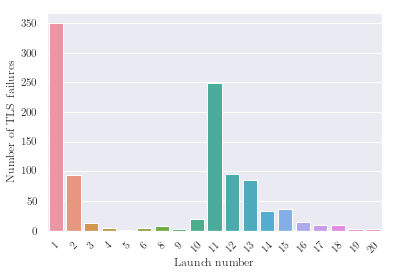

In [19]:
roku_fails  = roku_attempts[~roku_attempts.ssl_success]
plot_ssl_by(roku_fails, group_by="launch_no_int",
            filename="roku_ssl_fails_launch_no_combined.pdf",
           xlabel='Launch number', ylabel='Number of TLS failures')

In [20]:
roku_fails

,tcp_stream,frame_time_epoch,ip_src,tcp_srcport,ip_dst,tcp_dstport,channel_id,mitm_attempt,host_by_dns,domain_by_dns,...,playback,status,host,domain,ssl_success,crawl_status,epoch,n_smart_crawl_launch,launch_no,launch_no_int
10910,46,1.556351e+09,10.42.0.119,58493,34.236.215.144,443,195316,True,scribe.logs.roku.com,roku.com,...,False,TERMINATED,scribe.logs.roku.com,roku.com,False,TERMINATED,launch-01,-1,launch-01,1
10925,50,1.556351e+09,10.42.0.119,47216,172.217.11.46,443,195316,True,www.youtube-nocookie.com,youtube-nocookie.com,...,False,TERMINATED,www.youtube.com,youtube.com,False,TERMINATED,launch-01,-1,launch-01,1
11030,64,1.556351e+09,10.42.0.119,34243,172.217.3.106,443,195316,True,fonts.googleapis.com,fonts.googleapis.com,...,False,TERMINATED,fonts.googleapis.com,fonts.googleapis.com,False,TERMINATED,launch-02,-1,launch-02,2
11334,66,1.556351e+09,10.42.0.119,36206,172.217.10.2,443,195316,True,googleads.g.doubleclick.net,doubleclick.net,...,False,TERMINATED,googleads.g.doubleclick.net,doubleclick.net,False,TERMINATED,launch-02,-1,launch-02,2
11349,67,1.556351e+09,10.42.0.119,60347,172.217.12.131,443,195316,True,fonts.gstatic.com,gstatic.com,...,False,TERMINATED,fonts.gstatic.com,gstatic.com,False,TERMINATED,launch-02,-1,launch-02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25840,157,1.556432e+09,10.42.0.119,37481,172.217.7.2,443,219692,True,pubads.g.doubleclick.net,doubleclick.net,...,False,TERMINATED,pubads.g.doubleclick.net,doubleclick.net,False,TERMINATED,launch-06,-1,launch-06,6
25859,159,1.556432e+09,10.42.0.119,49709,172.217.12.161,443,219692,True,tpc.googlesyndication.com,googlesyndication.com,...,False,TERMINATED,tpc.googlesyndication.com,googlesyndication.com,False,TERMINATED,launch-06,-1,launch-06,6
1003,44,1.556425e+09,10.42.0.119,36105,34.197.122.214,443,176562,True,scribe.logs.roku.com,roku.com,...,True,TERMINATED,scribe.logs.roku.com,roku.com,False,TERMINATED,launch-01,-1,launch-01,1
3033,226,1.556425e+09,10.42.0.119,36455,207.241.227.81,443,176562,True,ia601601.us.archive.org,archive.org,...,True,TERMINATED,ia601601.us.archive.org,archive.org,False,TERMINATED,smartlaunch-01-key-seq-01-key-02,1,smartlaunch-01,11


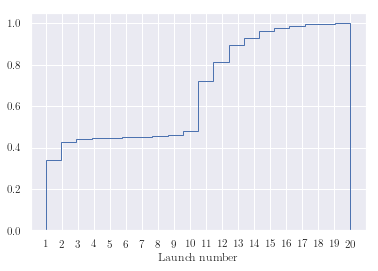

In [21]:
ax = roku_fails['launch_no_int'].hist(cumulative=True, bins=20, density=True, histtype="step")
ax.set(xlabel="Launch number")
plt.xticks(np.arange(min(roku_fails['launch_no_int']), max(roku_fails['launch_no_int'])+1, 1.0))
fig = ax.get_figure()
fig.savefig('cdf_warmup_param_selection_step.pdf', bbox_inches='tight')

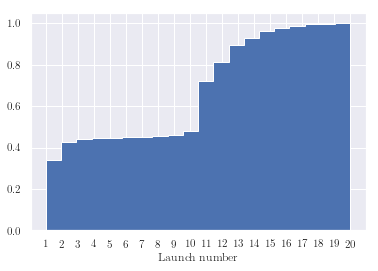

In [22]:
ax = roku_fails['launch_no_int'].hist(cumulative=True, bins=20, density=True, histtype="stepfilled")
ax.set(xlabel="Launch number")
plt.xticks(np.arange(min(roku_fails['launch_no_int']), max(roku_fails['launch_no_int'])+1, 1.0))
fig = ax.get_figure()
fig.savefig('cdf_warmup_param_selection_stepfilled.pdf', bbox_inches='tight')

/home/hooman/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


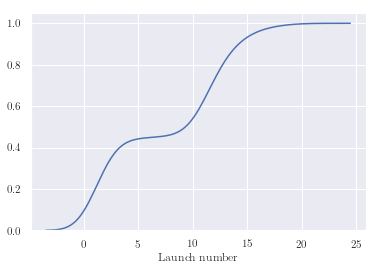

In [23]:
ax = sns.kdeplot(roku_fails['launch_no_int'], cumulative=True, legend=False)
ax.set(xlabel="Launch number")
#plt.xticks(np.arange(min(roku_fails['launch_no_int']), max(roku_fails['launch_no_int'])+1, 1.0))
fig = ax.get_figure()
fig.savefig('kde_warmup_param_selection.pdf', bbox_inches='tight')

## Parameter selection

In [24]:
n_ssl_errs_after_5th_smart_crawl = len(roku_fails[roku_fails.n_smart_crawl_launch > 5])

In [25]:
n_ssl_errs_before_5th_smart_crawl = len(roku_fails[roku_fails.n_smart_crawl_launch <= 5])

In [26]:
cdf_at_5th_smart = 100*n_ssl_errs_before_5th_smart_crawl / (n_ssl_errs_after_5th_smart_crawl + n_ssl_errs_before_5th_smart_crawl)
print("%0.1f%% of the errors are encountered on or before 5th smart crawl" % cdf_at_5th_smart)

96.4% of the errors are encountered on or before 5th smart crawl


### MITM Fails during smart crawl

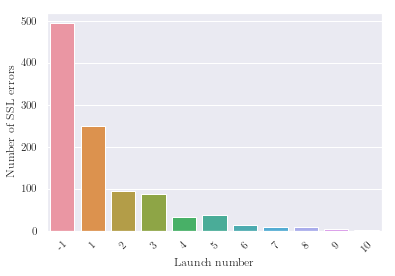

In [27]:
plot_ssl_by(roku_fails, group_by='n_smart_crawl_launch')

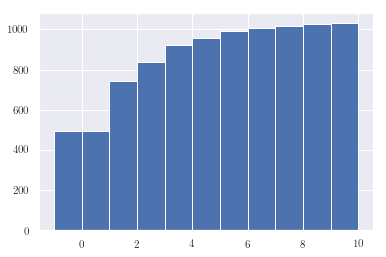

In [28]:
roku_fails['n_smart_crawl_launch'].hist(cumulative=True, bins=11)

/home/hooman/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


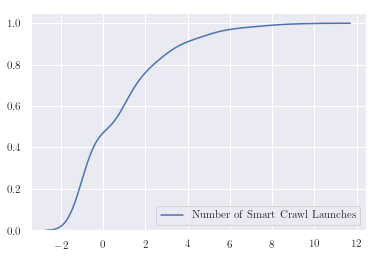

In [29]:
group_by = "n_smart_crawl_launch"
r_n_smart_crawl_launch = roku_fails['n_smart_crawl_launch']
r_n_smart_crawl_launch.name = 'Number of Smart Crawl Launches'
sns.kdeplot(r_n_smart_crawl_launch
            , cumulative=True
           )


### MITM Fails during channel relaunch

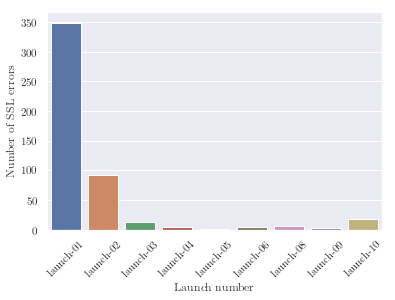

In [30]:
plot_ssl_by(roku_relaunch_fails, filename="images/roku_relaunch_fails.pdf")

## Late stage MITM fails
- why do we still have mitm fails in later stages
- it looks like, these are indeer hosts we have not seen before

In [31]:
roku_fails[roku_fails.n_smart_crawl_launch > 5].host_by_dns.value_counts().head(10)

www.google-analytics.com                          4
secure-gg.imrworldwide.com                        2
us-west-2.event.prod.bidr.io                      2
d.agkn.com                                        2
ade.googlesyndication.com                         2
secure-gl.imrworldwide.com                        2
ads.samba.tv                                      1
video-transcoded-api-main-awesomeads.sacdn.net    1
pippio.com                                        1
bs.serving-sys.com                                1
Name: host_by_dns, dtype: int64

In [32]:
# No of channels failing on last smart crawl attempt
print(roku_smartcrawl_fails[roku_smartcrawl_fails.n_smart_crawl_launch==4].channel_id.nunique(),  roku_df.channel_id.nunique())

13 141


In [33]:
print(roku_smartcrawl_fails[roku_smartcrawl_fails.n_smart_crawl_launch==3].channel_id.nunique(),  roku_df.channel_id.nunique())

25 141
